In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed, ConvLSTM2D, BatchNormalization, Flatten, MaxPooling3D
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc

def plot_roc(true_labels, scores, label):
    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return roc_auc

In [2]:
# Load the data (replace with your dataset file if applicable)
data = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

data

,value,day_of_week,min_temp,max_temp,season,hour_sin
timestamp,,,,,,
2014-07-01 00:00:00,0.276506,2,0.927536,0.957746,0,-0.000000
2014-07-01 00:30:00,0.207175,2,0.927536,0.958333,0,-0.130526
2014-07-01 01:00:00,0.158259,2,0.927536,0.958920,0,-0.258819
2014-07-01 01:30:00,0.118605,2,0.927536,0.959507,0,-0.382683
2014-07-01 02:00:00,0.097272,2,0.927536,0.960094,0,-0.500000
...,...,...,...,...,...,...
2015-01-31 21:30:00,0.629309,6,0.163345,0.196596,2,0.608761
2015-01-31 22:00:00,0.656128,6,0.165459,0.199531,2,0.500000
2015-01-31 22:30:00,0.696650,6,0.167572,0.202465,2,0.382683


In [3]:
# Prepare data
sequence_length = 48
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append((seq, label))
    return np.array(sequences, dtype=object)

true_anomalies_dates = [
    '2014-11-02', '2014-11-27', '2014-12-25',
    '2015-01-01',
    '2015-01-26', '2015-01-27'
]

# Add true anomaly labels to the DataFrame
data['is_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
# true_labels = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_labels = data['is_anomaly'][sequence_length:].values

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 48, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,079 (121.40 KB)

 Trainable params: 31,079 (121.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.5297 - val_loss: 0.0607
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0978 - val_loss: 0.0446
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0767 - val_loss: 0.0332
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0639 - val_loss: 0.0308
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0593 - val_loss: 0.0294
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0577 - val_loss: 0.0269
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0561 - val_loss: 0.0273
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0500 - val_loss: 0.0217
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0494 - val_loss: 0.0259
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0436 - val_loss: 0.0223
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


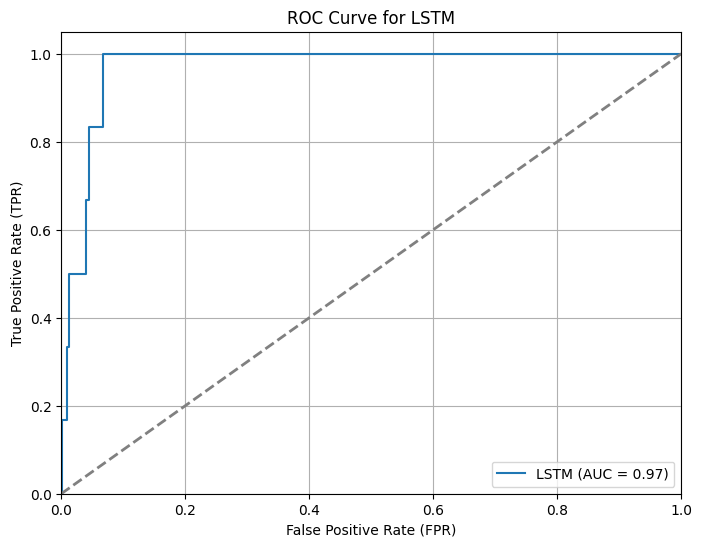

0.9708909669459056

In [4]:
# Create sequences for input
sequences1 = create_sequences(data.values, sequence_length)
X1, y1 = zip(*sequences1)
X1, y1 = np.array(X1), np.array(y1)

# --- LSTM Model ---
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X1.shape[1], X1.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(X1.shape[2])
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

history_lstm = model_lstm.fit(X1, y1, epochs=10, batch_size=32, validation_split=0.2)
predictions_lstm = model_lstm.predict(X1)
X1_last = X1[:, -1, :]
reconstruction_error_lstm = np.mean(np.abs(predictions_lstm - X1_last), axis=1)

plot_roc(true_labels, reconstruction_error_lstm, 'LSTM')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 48, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 48, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 48, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 48, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 48, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 48, 7)               │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,455 (251.78 KB)

 Trainable params: 64,455 (251.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - loss: 0.7272 - val_loss: 0.2709
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.2388 - val_loss: 0.2250
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - loss: 0.1802 - val_loss: 0.1462
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - loss: 0.1519 - val_loss: 0.1395
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - loss: 0.1371 - val_loss: 0.1273
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.1108 - val_loss: 0.0675
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - loss: 0.0858 - val_loss: 0.0615
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.0756 - val_loss: 0.0468
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.0685 - val_loss: 0.0451
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 0.0636 - val_loss: 0.0408
321/321 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step


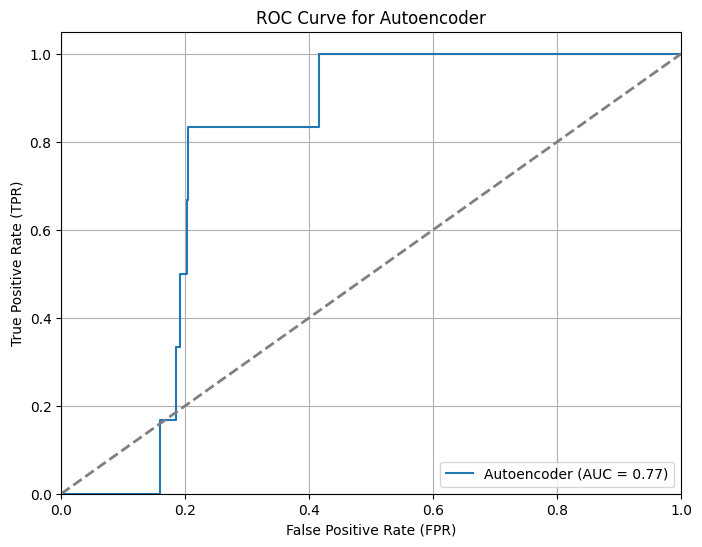

0.7733781414377557

In [5]:
# --- Autoencoder Model ---
sequences2 = create_sequences(data.values, sequence_length)
X2 = np.array([seq[0] for seq in sequences2])

model_lstm_autoencoder = Sequential([
    # Encoder part
    LSTM(64, return_sequences=True, input_shape=(X2.shape[1], X2.shape[2])),  # Return sequences to pass to the next layer
    Dropout(0.2),
    LSTM(32, return_sequences=False),  # Encodes to a single vector representation
    Dropout(0.2),

    # Decoder part
    RepeatVector(X2.shape[1]),  # Repeat the encoded vector for each timestep in the sequence
    LSTM(32, return_sequences=True),  # Decode the sequence
    Dropout(0.2),
    LSTM(64, return_sequences=True),  # Decode back to the original sequence length
    Dropout(0.2),

    # Output layer: Same shape as the input sequence
    TimeDistributed(Dense(X2.shape[2]))  # For sequence-to-sequence output
])

model_lstm_autoencoder.compile(optimizer='adam', loss='mse')
model_lstm_autoencoder.summary()

# Train the model
history_lstm_ae = model_lstm_autoencoder.fit(X2, X2, epochs=10, batch_size=32, validation_split=0.2)

reconstructed_ae = model_lstm_autoencoder.predict(X2)
reconstruction_error_ae = np.mean(np.abs(reconstructed_ae - X2), axis=(1, 2))

plot_roc(true_labels, reconstruction_error_ae, 'Autoencoder')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 48, 1, 6, 64)        │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 1, 6, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 48, 1, 3, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 48, 1, 3, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 336)                 │          21,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 645,520 (2.46 MB)

 Trainable params: 645,392 (2.46 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 61s 228ms/step - loss: 1.3529 - val_loss: 1.5318
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 71s 184ms/step - loss: 1.2052 - val_loss: 1.3613
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - loss: 1.1771 - val_loss: 1.3498
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 62s 241ms/step - loss: 1.1842 - val_loss: 1.3455
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 68s 185ms/step - loss: 1.1953 - val_loss: 1.3446
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - loss: 1.1917 - val_loss: 1.3435
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 46s 179ms/step - loss: 1.1734 - val_loss: 1.3434
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - loss: 1.1942 - val_loss: 1.3449
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step - loss: 1.2042 - val_loss: 1.3442
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - loss: 1.1785 - val_loss: 1.3443
321/321 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step


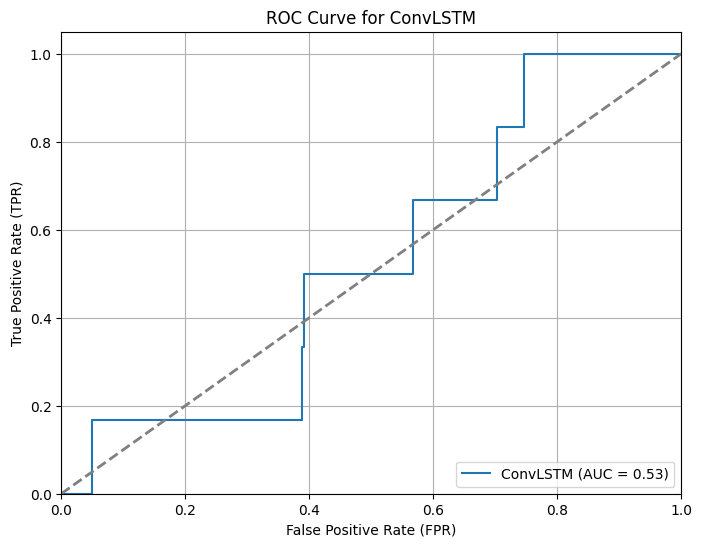

0.5255211377362167

In [6]:
# --- ConvLSTM Model ---
sequences3 = create_sequences(data.values, sequence_length)
X3 = np.array([seq[0] for seq in sequences3])
X3 = X3.reshape((X3.shape[0], X3.shape[1], 1, X3.shape[2], 1))

model_convlstm = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(X3.shape[1], 1, X3.shape[3], 1), return_sequences=True),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 1, 2)),  # Pool across temporal and spatial dimensions
    Dropout(0.3),

    # Second ConvLSTM layer
    # ConvLSTM2D(filters=32, kernel_size=(1, 2), activation='relu', return_sequences=True),
    # BatchNormalization(),
    # MaxPooling3D(pool_size=(1, 1, 2)),  # Pool across temporal and spatial dimensions
    # Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(X3.shape[1] * X3.shape[3], activation='sigmoid')])

model_convlstm.compile(optimizer='adam', loss='mse')
model_convlstm.summary()

X3_flattened = X3.reshape(X3.shape[0], -1)
history_convlstm = model_convlstm.fit(X3, X3_flattened, epochs=10, batch_size=32, validation_split=0.2)
reconstructed_convlstm = model_convlstm.predict(X3).reshape(X3.shape[0], -1)
reconstruction_error_convlstm = np.mean(np.abs(reconstructed_convlstm - X3_flattened), axis=1)

plot_roc(true_labels, reconstruction_error_convlstm, 'ConvLSTM')

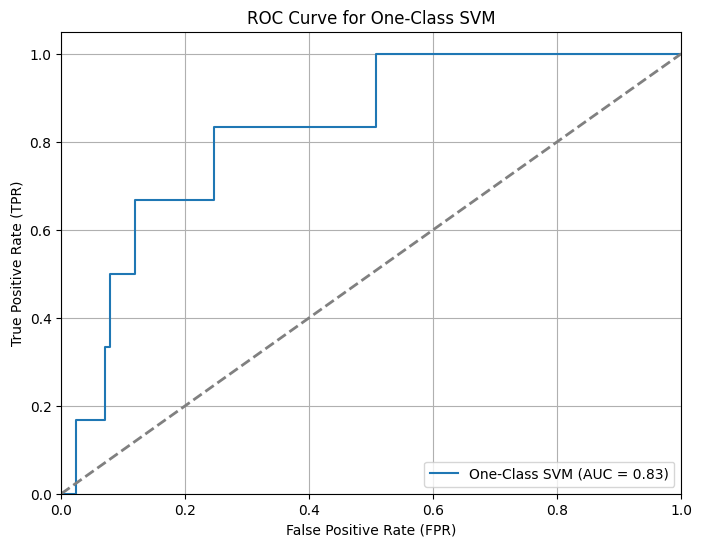

0.8256253635834788

In [7]:
# --- One-Class SVM Model ---
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm.fit(data.values)
scores_svm = -svm.decision_function(data.values)
true_labels4 = data['is_anomaly'].values

plot_roc(true_labels4, scores_svm, 'One-Class SVM')

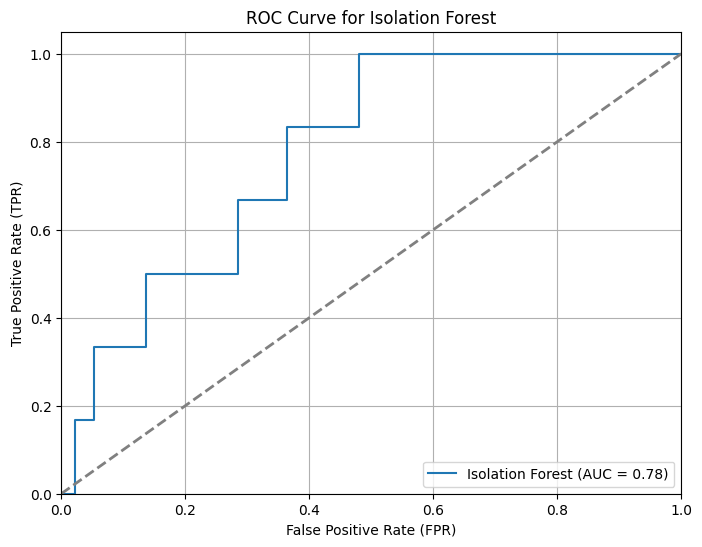

0.7766413403467757

In [8]:
# --- Isolation Forest Model ---
sequences5 = create_sequences(data.values, sequence_length)
X5 = np.array([seq[0] for seq in sequences5])
X5_flattened = X5.reshape(X5.shape[0], -1)

iso_forest = IsolationForest(n_estimators=300, contamination=0.05, random_state=10)
iso_forest.fit(X5_flattened)
scores_iso_forest = -iso_forest.decision_function(X5_flattened)

plot_roc(true_labels, scores_iso_forest, 'Isolation Forest')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.5915 - val_loss: 0.0638
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.1067 - val_loss: 0.0344
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0816 - val_loss: 0.0432
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0730 - val_loss: 0.0285
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0643 - val_loss: 0.0259
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


<ipython-input-16-50b4fbbdf0fa>:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[true_labels == 0], errors[true_labels == 1]],


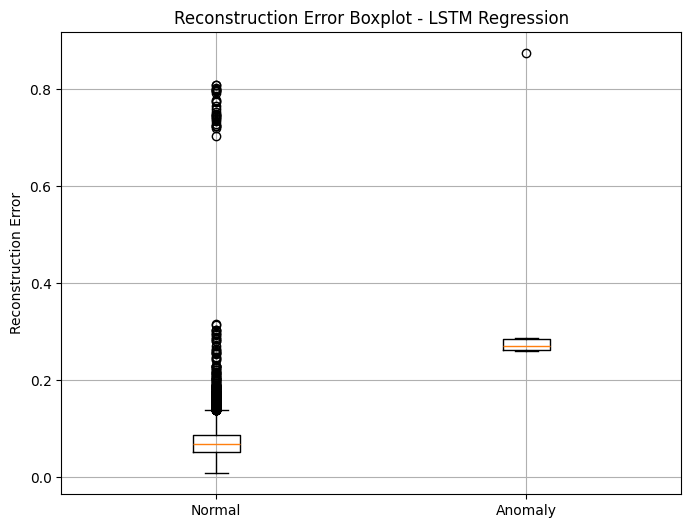

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - loss: 0.7246 - val_loss: 0.2544
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - loss: 0.2369 - val_loss: 0.1801
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - loss: 0.1760 - val_loss: 0.1444
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - loss: 0.1548 - val_loss: 0.1336
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - loss: 0.1464 - val_loss: 0.1205
321/321 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


<ipython-input-16-50b4fbbdf0fa>:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[true_labels == 0], errors[true_labels == 1]],


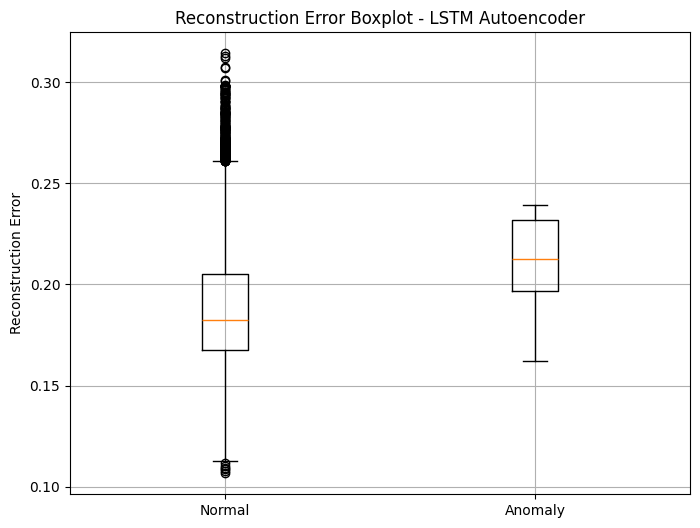

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 48s 175ms/step - loss: 1.3381 - val_loss: 1.5289
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 84s 182ms/step - loss: 1.1958 - val_loss: 1.3593
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 80s 175ms/step - loss: 1.1843 - val_loss: 1.3467
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - loss: 1.1908 - val_loss: 1.3443
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 84s 181ms/step - loss: 1.1661 - val_loss: 1.3434
321/321 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step


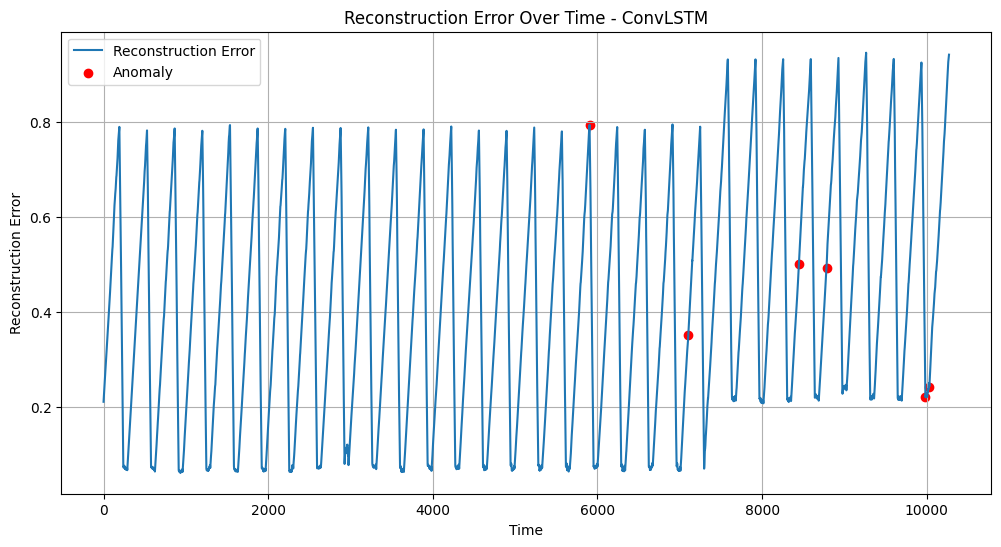

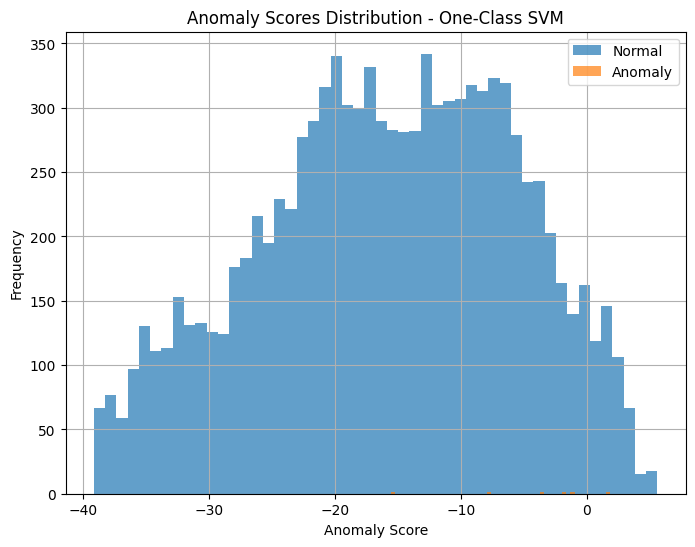

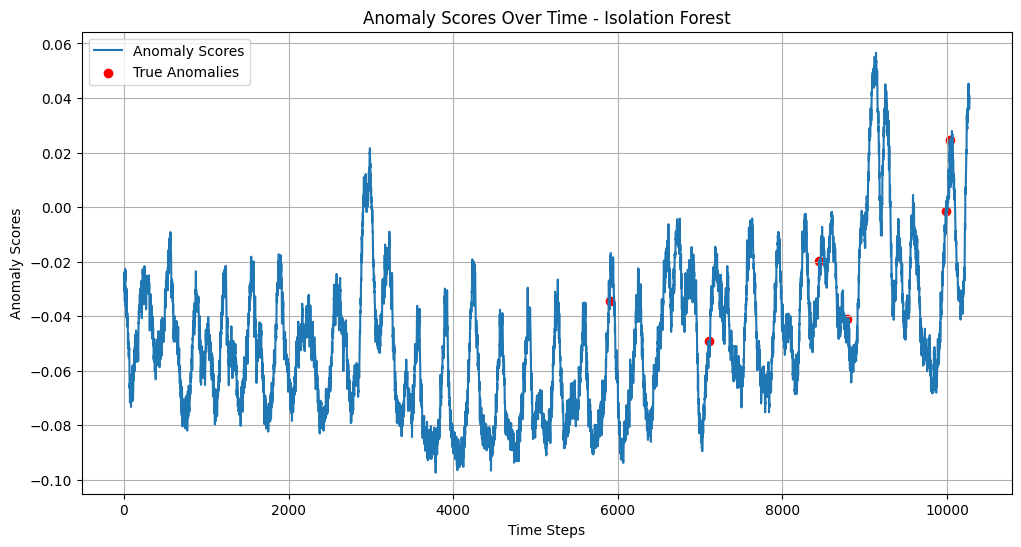

<ipython-input-16-50b4fbbdf0fa>:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[true_labels == 0], errors[true_labels == 1]],


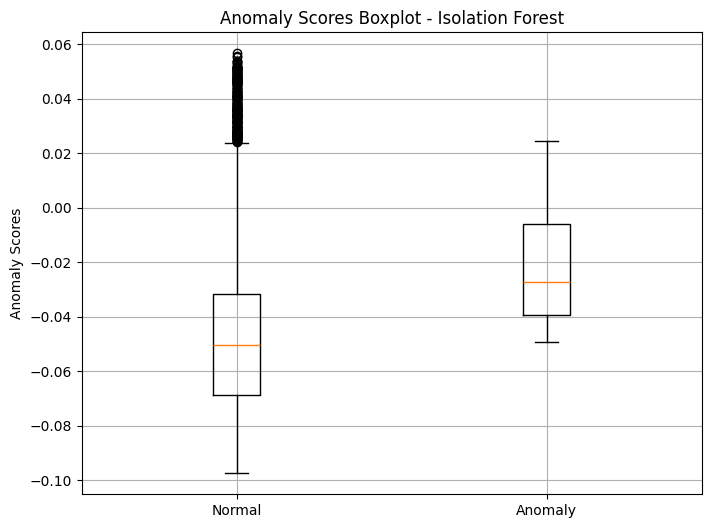

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, precision_recall_curve, auc, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, ConvLSTM2D, BatchNormalization, Flatten, MaxPooling3D

# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Add true anomaly labels
true_anomalies_dates = ['2014-11-02', '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-26', '2015-01-27']
data['is_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_labels = data['is_anomaly'].values

# Prepare sequences
sequence_length = 48
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append((seq, label))
    return np.array(sequences, dtype=object)

# Create sequences for all models
sequences = create_sequences(data.values, sequence_length)
X = np.array([seq[0] for seq in sequences])
y = np.array([seq[1] for seq in sequences])

X_flattened = X.reshape(X.shape[0], -1)
aligned_true_labels = true_labels[sequence_length:]  # Align true labels with model outputs

# Visualization functions
def plot_boxplot(errors, true_labels, label):
    plt.figure(figsize=(8, 6))
    plt.boxplot([errors[true_labels == 0], errors[true_labels == 1]],
                labels=['Normal', 'Anomaly'])
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Error Boxplot - {label}')
    plt.grid()
    plt.show()

def plot_time_series(errors, true_labels, label):
    plt.figure(figsize=(12, 6))
    plt.plot(errors, label='Reconstruction Error')
    plt.scatter(np.where(true_labels == 1)[0], errors[true_labels == 1], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Error Over Time - {label}')
    plt.legend()
    plt.grid()
    plt.show()

def plot_precision_recall(true_labels, scores, label):
    precision, recall, _ = precision_recall_curve(true_labels, scores)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {label}')
    plt.legend()
    plt.grid()
    plt.show()

# 1. LSTM Regression Model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(X.shape[2])
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)
predictions_lstm = model_lstm.predict(X)
reconstruction_error_lstm = np.mean(np.abs(predictions_lstm - y), axis=1)
plot_boxplot(reconstruction_error_lstm, aligned_true_labels, 'LSTM Regression')

# 2. LSTM Autoencoder
model_autoencoder = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    RepeatVector(X.shape[1]),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(X.shape[2]))
])
model_autoencoder.compile(optimizer='adam', loss='mse')
model_autoencoder.fit(X, X, epochs=5, batch_size=32, validation_split=0.2)
reconstructed_ae = model_autoencoder.predict(X)
reconstruction_error_ae = np.mean(np.abs(reconstructed_ae - X), axis=(1, 2))
plot_boxplot(reconstruction_error_ae, aligned_true_labels, 'LSTM Autoencoder')

# 3. ConvLSTM2D Model
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1, X.shape[2], 1))
model_convlstm = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(X_reshaped.shape[1], 1, X_reshaped.shape[3], 1), return_sequences=True),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 1, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(X_reshaped.shape[1] * X_reshaped.shape[3], activation='sigmoid')
])
model_convlstm.compile(optimizer='adam', loss='mse')
model_convlstm.fit(X_reshaped, X_flattened, epochs=5, batch_size=32, validation_split=0.2)
reconstructed_conv = model_convlstm.predict(X_reshaped).reshape(X_flattened.shape)
reconstruction_error_conv = np.mean(np.abs(reconstructed_conv - X_flattened), axis=1)
plot_time_series(reconstruction_error_conv, aligned_true_labels, 'ConvLSTM')

# 4. One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm.fit(data.values)
scores_svm = -svm.decision_function(data.values)[sequence_length:]  # Align scores
plot_anomaly_scores(scores_svm, aligned_true_labels, 'One-Class SVM')

# 5. Isolation Forest
iso_forest = IsolationForest(n_estimators=300, contamination=0.05, random_state=10)
iso_forest.fit(X_flattened)
scores_iso = -iso_forest.decision_function(X_flattened)

# Time-series visualization
def plot_time_series(errors, true_labels, label):
    plt.figure(figsize=(12, 6))
    plt.plot(errors, label='Anomaly Scores')
    plt.scatter(np.where(true_labels == 1)[0], errors[true_labels == 1], color='red', label='True Anomalies')
    plt.xlabel('Time Steps')
    plt.ylabel('Anomaly Scores')
    plt.title(f'Anomaly Scores Over Time - {label}')
    plt.legend()
    plt.grid()
    plt.show()

# Boxplot visualization
def plot_boxplot(errors, true_labels, label):
    plt.figure(figsize=(8, 6))
    plt.boxplot([errors[true_labels == 0], errors[true_labels == 1]],
                labels=['Normal', 'Anomaly'])
    plt.ylabel('Anomaly Scores')
    plt.title(f'Anomaly Scores Boxplot - {label}')
    plt.grid()
    plt.show()

# Plot the new visualizations
plot_time_series(scores_iso, aligned_true_labels, 'Isolation Forest')
plot_boxplot(scores_iso, aligned_true_labels, 'Isolation Forest')
